In [29]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torchinfo import summary
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [57]:
torch.__version__

'2.0.0+cu117'

In [30]:
# Ensure we're working in the directory of this file
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface')
initial_wd = os.getcwd()

# Latex fonts
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [31]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force*10**-6

def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    E = E * 10**3 # kPa to Pa
    i = i * 10**-9 # nm to m
    r = r * 10**-9 # nm to m
    gamma = gamma * 10**-6 # microJ/m^2 to J/m^2
    E_eff = E / (1 - nu**2)
    K = 4/3 * E_eff
    Ua = np.sqrt(6*np.pi*gamma)
    # JKR force formula in (3)
    force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    # return force*10**-6
    return force*10**9

In [32]:
# resolution of the map
res = 200
# random values
size = res * res

# Seed (if needed)
np.random.seed(42)

# Triangular distrbution
E = np.random.triangular(left=0.2, mode=1.8, right=10, size=size)

# Poisson's ratio 
nu = 0.5

# surface energy
gamma = abs(np.random.uniform(low=1., high=3., size=size))

# radius of the indenter
r = 1980.0 # (nm)

In [33]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-800, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 150, 50

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts+1)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
# Seed (if needed)
np.random.seed(42)

rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts+1).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
'''fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,4))
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Displacement')
# ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')

ax2.hist(E, 10, ec='black')
ax3.set_xlabel('$\gamma$ ($\mu$J/m$^2$)')
ax3.set_ylabel('Frequency')
ax3.hist(gamma, 10, ec='black')'''

"fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,4))\n# ax1.set_xlabel('Time (s)')\n# ax1.set_ylabel('Displacement')\n# ax1.plot(t, ramp)\nax2.set_xlabel('E (kPa)')\nax2.set_ylabel('Frequency')\n\nax2.hist(E, 10, ec='black')\nax3.set_xlabel('$\\gamma$ ($\\mu$J/m$^2$)')\nax3.set_ylabel('Frequency')\nax3.hist(gamma, 10, ec='black')"

In [34]:
# construct dataframe
df = pd.DataFrame()
# 'E' and 'gamma' arrays to list:
df['E'] = E.tolist()
df['gamma'] = gamma.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, x.gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)

C:\Users\luisr\AppData\Local\Temp\ipykernel_23812\566930558.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_23812\566930558.py:59: RuntimeWarning: invalid value encountered in power
  force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75


# **HERTZ**

In [35]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>0]) # Para considerar o 0: x>=0
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact):]) # len(no_contact)-1
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of indentation and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape, df_hc['approach_contact'][0])

(50,) (50,) [  3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.  42.
  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.  84.
  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123. 126.
 129. 132. 135. 138. 141. 144. 147. 150.]


### Inputs and labels

In [36]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
print(x_hc.shape, y_hc.shape)

(40000, 2) (40000,)


### Splitting data into 6 folds

In [37]:
def tensor_input_shape(nparray):
    '''
    Training and test data from np arrays to torch tensor with desired shape
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((np.array(nparray[i,0]).reshape((n_pts,1)), np.array(nparray[i,1]).reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

In [38]:
test_ratio = 0.15
rnd_state = 42

# Bins for stratification
bin_count = 100
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

x_train.shape, y_train.shape, y_train[:5], y_train.reshape(-1,1)[:5], y_train.T[:5]

((34000, 2),
 (34000,),
 array([5.07069319, 7.58736473, 1.80695916, 3.72038722, 2.92083938]),
 array([[5.07069319],
        [7.58736473],
        [1.80695916],
        [3.72038722],
        [2.92083938]]),
 array([5.07069319, 7.58736473, 1.80695916, 3.72038722, 2.92083938]))

In [39]:
test_ratio = 0.15
rnd_state = 10

# Bins for stratification
bin_count = 100
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=rnd_state)
# Continuous target variables -> Categorical bins
y_bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
# Adds target column to x array (for later division) - UNNECESSARY (???? we can go get directly the information from y_train in the next loop) 
cv_dataset = np.concatenate((x_train, y_train.reshape(-1,1)),axis=1)

train_list, valid_list = [], [] 

for i, (train_index, test_index) in enumerate(skf.split(cv_dataset, y_bins)):
    # Extract target values for the current fold
    train_fold = cv_dataset[train_index]
    print(train_fold.shape)
    train_list.append(train_fold)
    valid_fold = cv_dataset[test_index]
    valid_list.append(valid_fold)

# Test data to tensors
x_test_t = tensor_input_shape(x_test)
y_test_t = torch.from_numpy(y_test).type(torch.float).unsqueeze(dim=1)
print(f"Shape of the test tensors (x, y): {x_test_t.shape, y_test_t.shape}")



(28333, 3)


(28333, 3)
(28333, 3)
(28333, 3)
(28334, 3)
(28334, 3)
Shape of the test tensors (x, y): (torch.Size([6000, 50, 2]), torch.Size([6000, 1]))


In [40]:
# Do this for each fold in the CV loop

train_idx, test_idx = next(skf.split(cv_dataset, y_bins))
print(f"Shape of the split outputs (train, valid): {train_idx.shape, test_idx.shape}")
print("These are just the indices of the training and validation instances of the current fold")
train_data = cv_dataset[train_idx]
valid_data = cv_dataset[test_idx]
print(f"Shape of the training and validation folds: {train_data.shape, valid_data.shape}")
x_train = train_data[:,:2]
y_train = train_data[:,2:].astype(float)
print(f"Shape of the training arrays (x, y): {x_train.shape, y_train.shape}")
x_train_t = tensor_input_shape(x_train)
y_train_t = torch.from_numpy(y_train).type(torch.float)
print(f"Shape of the training tensors (x, y): {x_train_t.shape, y_train_t.shape}")

Shape of the split outputs (train, valid): ((28333,), (5667,))
These are just the indices of the training and validation instances of the current fold
Shape of the training and validation folds: ((28333, 3), (5667, 3))
Shape of the training arrays (x, y): ((28333, 2), (28333, 1))
Shape of the training tensors (x, y): (torch.Size([28333, 50, 2]), torch.Size([28333, 1]))


In [41]:
y_train = y_train.astype(float)
torch.from_numpy(y_train).type(torch.float).shape

torch.Size([28333, 1])

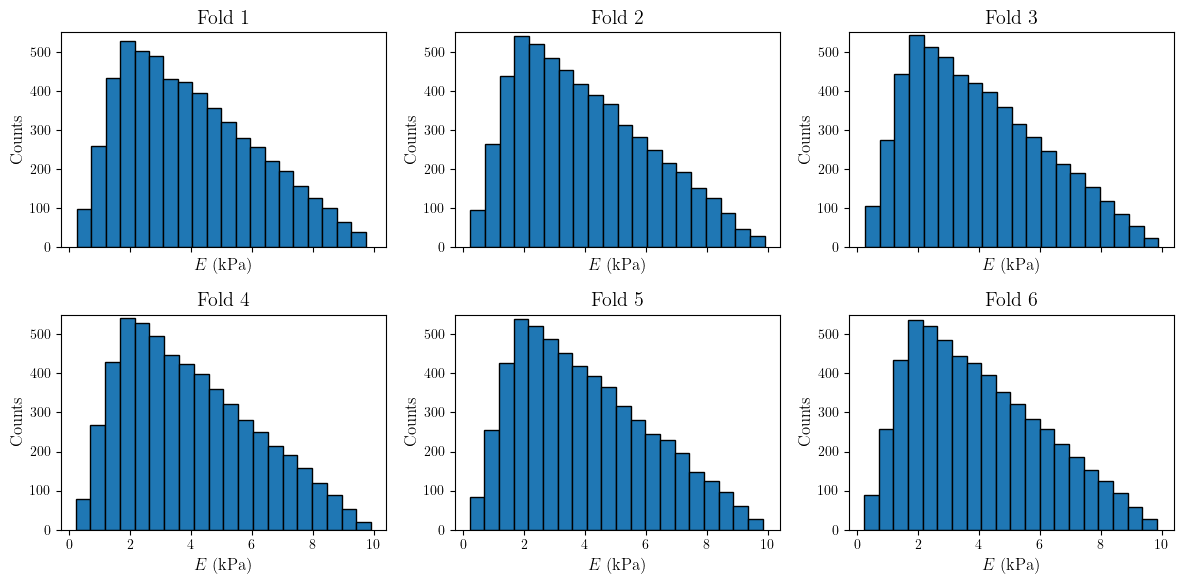

In [42]:
# Visualize target stratification in all folds

# Create subplots
list_of_arrays = valid_list
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=True)

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate through each array in the list
for i, (array, ax) in enumerate(zip(list_of_arrays, axes)):

    # Extract the third column of the array
    third_column = array[:, 2]

    # Plot histogram
    ax.hist(third_column, bins=20, edgecolor='black')
    ax.set_title(f'Fold {i + 1}')
    ax.set_ylim(0, 550)
    ax.set_xlabel('$E$ (kPa)')
    ax.set_ylabel('Counts')

# Adjust layout
plt.tight_layout()
plt.show()

## ML

In [43]:
# Auxiliary functions

def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

def data_as_pkl(dataset_list: list):
  file_names = ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']
  new_dir = 'Train_Validation_Data'
  current_path = os.getcwd()
  os.mkdir(new_dir)
  os.chdir(new_dir)
  for i, array in enumerate(dataset_list):
    with open(file_names[i]+'.pkl', 'wb') as f:
      pickle.dump(array, f)
  os.chdir(current_path)

def plot_loss_curve(epochs, mse_training, mse_validation, loss: bool):
  plt.ioff()
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()  
  # We're not going to plot the first epoch (>>greater loss)
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  if loss:
    plt.yscale('log')
    plt.savefig('loss_plot.pdf', bbox_inches='tight') 
  else:
    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.savefig('error_plot.pdf', bbox_inches='tight')
  # plt.show()
  plt.close()

def plot_error_hist(error_list, test: bool, **kwargs):
  plt.ioff()
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  fig, ax = plt.subplots()
  # plt.figure()
  x_values = [2.5, 10]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,15)) # to remove outliers, set parameter 'range='
  ax.set_xlabel("Error $E$ (\%)", fontsize=14)
  ax.set_ylabel("Density", fontsize=14)
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<10\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    ax.text(0.705, 0.93, 'Experimental test set ($n=24,304$)', transform=ax.transAxes, fontsize=13, ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig('error_hist_test.pdf', bbox_inches='tight')
  else:
    fig.savefig('error_hist_valid.pdf', bbox_inches='tight')
  plt.close(fig)

  

def plot_bad_curves(verror_list, list_inputs, list_labels, test: bool):
  plt.ioff()
  bad_curves = [(i, j) for i, j in enumerate(verror_list) if j > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(verror_list)], key= lambda k:k[1], reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for j, (i, _) in enumerate(bad_curves):
    if j < 5:
      tensor_idx = i//len(list_inputs[0])
      tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
      plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
              tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
              alpha=0.75,
              label=f'E={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),3)} kPa, $\epsilon$={verror_list[i]: .2f}\%')
  
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf', bbox_inches='tight')
  else:
    plt.savefig('bad_curves_valid.pdf', bbox_inches='tight')
  plt.close()

def plot_pred_real_curves(verror_list, list_inputs, list_labels, test: bool, list_predicts, nu, r,exp:bool):
  plt.ioff()
  bad_curves = []
  bad_curves_15 = sorted([(i, j) for i, j in enumerate(verror_list) if j > 15], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, _) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx], list_predicts[tensor_idx]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict = tensor_predicts[i-tensor_idx*len(list_inputs[0])].item()
    y2 = hertz(x, predict, nu, r)
    ax.plot(x,
             y1,
             alpha=0.75,
             label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),1)} kPa, $\epsilon$={verror_list[i]: .1f} \%',
             color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  if not exp:
    bbox_y = [0.85, 0.79, 0.73]
  else:
    bbox_y = [0.75, 0.69, 0.64]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
    fig.savefig('test_pred_vs_real_curves.pdf', bbox_inches='tight')
  else:
    fig.savefig('valid_pred_vs_real_curves.pdf', bbox_inches='tight')
  plt.close()

def error_fn(predict_tensor, label_tensor):
  '''
  INPUTS: * two tensors - true labels and predicts
  OUTPUTS: * scalar - mean relative error (in %) between both tensors
           * list - relative error (%) for each prediction
  '''
  error = abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).mean().item()
  error_list = list(abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).detach().numpy())
  return error, error_list

def plot_error_hist3(error_list, test: bool, **kwargs):
  plt.ioff()
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error1 = y, error2_5 = z)'''
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [1, 2.5]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,6)) # to remove outliers, set parameter 'range='
  ax.set_xlabel("Error $E$ (\%)", fontsize=14)
  ax.set_ylabel("Density", fontsize=14)
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<1\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    ax.text(0.74, 0.93, f'Synthetic test set ($n=$ {len(error_list)})', transform=ax.transAxes, fontsize=13, ha='center', 
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig('error_hist_test2.pdf', bbox_inches='tight')
  else:
    fig.savefig('error_hist_valid_2.pdf', bbox_inches='tight')
  plt.close(fig)
  # plt.show()

def scatter_true_pred(list_labels, list_preds, set: int, exp: bool):
  '''Scatter plot of model predictions vs true outputs around a unitary slope line
    list_labels and list_preds: lists of one-valued tensors
    set: 0 - Validation, 1 - Test synthetic, 2 - Test experimental'''
  plt.ioff()
  if set == 2:
    labels_array = np.array([tensor.item() for tensor in list_labels])
    predicts_array = np.array([tensor.item() for tensor in list_preds])
  else:
    labels_array = np.array(list_labels[0].squeeze(dim=1).detach())
    predicts_array = np.array(list_preds[0].squeeze(dim=1).detach())
  if exp:
    x = np.linspace(0,5.5,100)
  else:
    x = np.linspace(0,10.2,100)
  plt.plot(x,x, color='orange', linewidth=2, label="Ideal predictions", alpha=0.8)
  plt.scatter(labels_array, predicts_array, alpha=0.5, edgecolors='black', label=f"Observations ($n = 6000$)")
  plt.legend(fontsize=14)
  plt.xlabel("True $E$ (kPa)")
  plt.ylabel("Predicted $E$ (kPa)")
  sets = ['valid', 'test_syn', 'test_exp']
  if exp:
    plt.xlim(0,5.5)
    plt.ylim(0,5.5)
    plt.savefig('scatter_' + sets[set] + '_5' + '.pdf', bbox_inches='tight')
  else:
    plt.xlim(0,10.2)
    plt.ylim(0,10.2)
    plt.savefig('scatter_' + sets[set] + '.pdf', bbox_inches='tight')
  plt.close()

In [44]:
class Hertz_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [45]:
# Test Dataloader
test_data = Hertz_Dataset(x_test_t, y_test_t)
test_loader=DataLoader(test_data,batch_size=len(test_data), shuffle=False)

In [46]:
# Prepare experimental data
df_exp = pd.read_pickle("df_final.pkl")
x_test_exp = np.array(df_exp[['ind', 'force']])
y_test_exp = np.array(df_exp['ehertz'])
print(x_test_exp.shape, y_test_exp.shape)

x_test_exp_t = tensor_input_shape(x_test_exp)
y_test_exp_t = torch.from_numpy(y_test_exp.astype(float)).type(torch.float).unsqueeze(dim=1)

test_exp_data = Hertz_Dataset(x_test_exp_t, y_test_exp_t)
test_exp_loader=DataLoader(test_exp_data)


(24304, 2) (24304,)


In [47]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE = 2.296e-4 # 2.296e-4
EPOCHS = 80 # 80
BATCH_SIZE = 16

# Size of each layer
HIDDEN_UNITS_1 = 256 # 256
HIDDEN_UNITS_2 = 256 # 256
HIDDEN_UNITS_3 = 32 # 32

# 1: 2 layers, 2: 3 layers
ARCHITECTURE = 2

In [48]:
def prep_dataloader(dataset, train_ids, test_ids):
    train_data = dataset[train_ids]
    valid_data = dataset[test_ids]
    x_train = train_data[:,:2]
    y_train = train_data[:,2:].astype(float)
    x_valid = valid_data[:,:2]
    y_valid = valid_data[:,2:].astype(float)
    x_train_t = tensor_input_shape(x_train)
    y_train_t = torch.from_numpy(y_train).type(torch.float)
    x_valid_t = tensor_input_shape(x_valid)
    y_valid_t = torch.from_numpy(y_valid).type(torch.float)
    train_data = Hertz_Dataset(x_train_t, y_train_t)
    valid_data = Hertz_Dataset(x_valid_t, y_valid_t)
    train_loader=DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=False)
    valid_loader=DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
    return train_loader, valid_loader

In [49]:
# Define the regression model
class Regression_Hertz(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3):
        super(Regression_Hertz, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1),
                                    nn.LeakyReLU(), # Change model parameters and in draft.py
                                    nn.Linear(HIDDEN_UNITS_1,HIDDEN_UNITS_2),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_2, HIDDEN_UNITS_3),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_3, 1))
    def forward(self, x):
        out = self.layers(x)
        return out
    
# Define input shape
input_shape = x_train_t.shape[1:]
# Instantiate the model (add these two lines at the beggining of each fold cycle)
torch.manual_seed(42)
model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3)

# Define the loss function and optimizer
loss_fn = nn.HuberLoss()
optimizer = torch.optim.Adam(model_Hertz.parameters(), 
                            lr=LEARNING_RATE)

In [50]:
def train_one_epoch(epoch_index, train_loader, optimizer): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_Hertz(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        error, _ = error_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        loss_list.append(loss.item())
        error_list.append(error)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_list

In [51]:
model_params = {'Epochs': EPOCHS, 
                'Learning Rate': LEARNING_RATE,
                'Batch Size': BATCH_SIZE,
                'Number of Hidden layers': ARCHITECTURE+1,
                'Type of layers': nn.Linear,
                'Activation function': nn.LeakyReLU(),
                'Architecture': ARCHITECTURE,
                'Hidden Units 1': HIDDEN_UNITS_1,
                'Hidden Units 2': HIDDEN_UNITS_2,
                'Hidden Units 3': HIDDEN_UNITS_3,
                'Input shape': list(input_shape),
                'Loss function': loss_fn,
                'Optimizer': optimizer,
                'nu': nu,
                'radius': r,
                'xmax': xmax}
# model_params

In [52]:
def train_model_Hertz(EPOCHS: int,
                      model,
                      tloader,
                      vloader,
                      loss_fn,
                      optimizer,
                      x_test_t, y_test_t
                      ):
    plt.ioff()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # Set new directory for new model
    # initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='hertz')
    best_vloss = 1_000_000.
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 'Train Error (%)', 'Mean Train Error (%)', 'Mean Val Error (%)']
    row = []
    # start timer counter
    start = datetime.now()
    for epoch in range(EPOCHS):
        # print('EPOCH {}:'.format(epoch + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        loss_list, error_list = train_one_epoch(epoch, tloader, optimizer) # (epoch, writer)
        # We don't need gradients on to do reporting
        model.train(False)
        running_vloss = 0.0
        running_verror = 0.0
        verror_list, fts_list, labels_list, predicts_list = [], [], [], []
        for i, vdata in enumerate(vloader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model(vinputs)
            predicts_list.append(voutputs)
            vloss = loss_fn(voutputs, vlabels)
            verror, verror_aux_list = error_fn(voutputs, vlabels)
            running_vloss += vloss
            running_verror += verror
            verror_list += verror_aux_list
        avg_vloss = running_vloss / (i + 1)
        avg_verror = running_verror / (i + 1)
        # print(f"Validation error in epoch {epoch+1}: {np.array(loss_list).mean():.3f}") ###~
        row.append(dict(zip(cols, 
                            [epoch+1, 
                            loss_list, 
                            np.array(loss_list).mean(), 
                            avg_vloss.item(), 
                            error_list, 
                            np.array(error_list).mean(), 
                            avg_verror])))
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_verror = avg_verror
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            #torch.save(model.state_dict(), model_path)
            verror_list_best = verror_list
            fts_list_best = fts_list
            labels_list_best = labels_list
            predicts_list_best = predicts_list
    end = datetime.now()
    model_params['Training Time'] = end - start
    print('Training time: {}'.format(model_params['Training Time']))
    print(f"Validation error (%): {best_verror}")
    torch.save(model.state_dict(), model_path)
    model_params['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    # plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True)
    # plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Error (%)'].values.tolist(), df['Mean Val Error (%)'].values.tolist(), loss=False)
    # plot_bad_curves(verror_list_best, fts_list_best, labels_list_best, test=False)
    # plot_pred_real_curves(verror_list_best, fts_list_best, labels_list_best, test=False, list_predicts=predicts_list_best, nu=nu, r=r)
    # plot_error_hist(verror_list_best, test=False)
    scatter_true_pred(labels_list_best, predicts_list_best, set = 0, exp=True)
    scatter_true_pred(labels_list_best, predicts_list_best, set = 0, exp=False)
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params.keys())
        writer.writeheader()
        writer.writerow(model_params)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    # os.chdir(initial_wd)

In [53]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    model.eval()
    loss, error = 0, 0
    error_list, fts_list, labels_list, predicts_list = [], [], [], []
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            loss += loss_fn(y_pred, test_labels) 
            error_aux, error_list_aux = error_fn(y_pred, test_labels)
            error += error_aux
            error_list += error_list_aux
        loss /= len(data_loader)
        error /= len(data_loader)
    np.save('error_list_test_syn.npy', np.array(error_list))
    error1 = len([i for i in error_list if i <= 1])/len(error_list)
    error2_5 = len([i for i in error_list if i <= 2.5])/len(error_list)
    error5 = len([i for i in error_list if i <= 5])/len(error_list)
    error10 = len([i for i in error_list if i <= 10])/len(error_list)
    print(f"Test Error (%): {error}")
    print(f"Test Curves under 5% (%): {error5*100}")
    results_dict = {"model_name": model.__class__.__name__,
                    "model_loss": loss.item(),
                    "model_error": error,
                    "under_1%_error": error1,
                    "under_2.5%_error": error2_5,
                    "under_5%_error": error5,
                    "under_10%_error": error10}
    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    plot_error_hist(error_list, test=True, error1=error2_5, error2=error10)
    plot_error_hist3(error_list, test=True, error1=error1, error2=error2_5)
    plot_bad_curves(error_list, fts_list, labels_list, test=True)
    plot_pred_real_curves(error_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, exp=False)
    scatter_true_pred(labels_list, predicts_list, set=1, exp=True)
    scatter_true_pred(labels_list, predicts_list, set=1, exp=False)
    print(results_dict)

In [54]:
def eval_model_experimental(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    # create a folder if it doesn't exist yet
    exp_dir = 'Test_Experimental'
    if not os.path.exists(exp_dir):     
        os.mkdir(exp_dir)
    os.chdir(exp_dir)
    model.eval()
    loss, error = 0, 0
    error_list, fts_list, labels_list, predicts_list, predicts_list2 = [], [], [], [], [] # pred_list2 is the list of predictions with only tensor items
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            predicts_list2.append(y_pred.item())
            loss += loss_fn(y_pred, test_labels) 
            error_aux, error_list_aux = error_fn(y_pred, test_labels)
            error += error_aux
            error_list += error_list_aux
        loss /= len(data_loader)
        error /= len(data_loader)
    error1 = len([i for i in error_list if i <= 1])/len(error_list)
    error2_5 = len([i for i in error_list if i <= 2.5])/len(error_list)
    error5 = len([i for i in error_list if i <= 5])/len(error_list)
    error10 = len([i for i in error_list if i <= 10])/len(error_list)
    print(f"Test Error (%): {error}")
    print(f"Test Curves under 10% (%): {error10*100}")
    print(f"Test Curves under 5% (%): {error5*100}")
    np.save('error_list.npy', np.array(error_list))
    np.save('predicts_list.npy', np.array(predicts_list2))
    results_dict = {"model_name": model.__class__.__name__,
                    "model_loss": loss.item(),
                    "model_error": error,
                    "under_1%_error": error1,
                    "under_2.5%_error": error2_5,
                    "under_5%_error": error5,
                    "under_10%_error": error10,
                    "total_curves": len(error_list)}
    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    plot_error_hist(error_list, test=True, error1=error2_5, error2=error10)
    plot_bad_curves(error_list, fts_list, labels_list, test=True)
    plot_pred_real_curves(error_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, exp=False)
    scatter_true_pred(labels_list, predicts_list, set = 2, exp=True)
    print(results_dict)
    os.chdir("..")

In [55]:
# Perform Cross-Validation ()
plt.ioff() # Turn off plotting display
k_folds = 6 # 6

# Stratified K-fold cross validator
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=14)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, valid_ids) in enumerate(skf.split(cv_dataset, y_bins)):
    os.chdir(initial_wd)
    # Prints
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    if fold == 2:
        # Dataset and DataLoader stuff
        train_loader, valid_loader = prep_dataloader(dataset=cv_dataset, train_ids=train_ids, test_ids=valid_ids)            

        # Initialize the NN
        input_shape = x_train_t.shape[1:]
        torch.manual_seed(42)
        model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3)
        optimizer = torch.optim.Adam(model_Hertz.parameters(), 
                                lr=LEARNING_RATE)
        # Start Training + Validation
        print("Training ...")
        plt.ioff()
        train_model_Hertz(EPOCHS, model_Hertz, train_loader, valid_loader, loss_fn, optimizer, x_test_t, y_test_t)
        
        # Start testing
        print("Testing on synthetic data...")
        eval_model(model_Hertz, test_loader, loss_fn, error_fn)
        print("Testing on experimental data...")
        eval_model_experimental(model_Hertz, test_exp_loader, loss_fn, error_fn)
        print('--------------------------------')

--------------------------------
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------


Training ...
Training time: 0:09:55.123312
Validation error (%): 0.32851526141166687
Testing on synthetic data...
Test Error (%): 0.9723677635192871
Test Curves under 5% (%): 98.83333333333333
{'model_name': 'Regression_Hertz', 'model_loss': 0.0003300985263194889, 'model_error': 0.9723677635192871, 'under_1%_error': 0.6621666666666667, 'under_2.5%_error': 0.9348333333333333, 'under_5%_error': 0.9883333333333333, 'under_10%_error': 0.999}
Testing on experimental data...
Test Error (%): 5.168417516107936
Test Curves under 10% (%): 85.94058591178407
Test Curves under 5% (%): 61.07636603028308
{'model_name': 'Regression_Hertz', 'model_loss': 0.007981432601809502, 'model_error': 5.168417516107936, 'under_1%_error': 0.15211487820934824, 'under_2.5%_error': 0.36109282422646477, 'under_5%_error': 0.6107636603028308, 'under_10%_error': 0.8594058591178407, 'total_curves': 24304}
--------------------------------
FOLD 4
--------------------------------
FOLD 5
--------------------------------
FOLD 

In [56]:
os.chdir(initial_wd)
os.getcwd()

'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface'